# Cart pole system identification example

In [1]:
import mujoco
import copy
import scipy
import numpy as np
from dm_control import mjcf

np.random.seed(0)

sim_model = mujoco.MjModel.from_xml_path("data/models/cart_pole/scene.xml")
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)

# LQR for swing-up and balancing control of the cart-pole system


In [2]:
def compute_gains(model, data, configuration, Q, R):
    # 1. Set configuration and find control that stabilizes it (ctrl0)
    newdata = mujoco.MjData(model)
    newdata = copy.copy(data)

    mujoco.mj_resetData(model, newdata)
    newdata.qpos = configuration
    # compute the control
    mujoco.mj_forward(model, newdata)
    newdata.qacc = 0
    mujoco.mj_inverse(model, newdata)

    # define control and configuration to linearize around
    print(newdata.qfrc_actuator)
    ctrl0 = newdata.qfrc_inverse.copy() @ np.linalg.pinv(newdata.actuator_moment)
    qpos0 = newdata.qpos.copy()

    # 2. Compute LQR gains given weights
    mujoco.mj_resetData(model, newdata)
    newdata.ctrl = ctrl0
    newdata.qpos = qpos0

    # 3. Allocate the A and B matrices, compute them.
    A = np.zeros((2 * model.nv, 2 * model.nv))
    B = np.zeros((2 * model.nv, model.nu))
    epsilon = 1e-6
    flg_centered = True
    mujoco.mjd_transitionFD(model, newdata, epsilon, flg_centered, A, B, None, None)

    # Solve discrete Riccati equation.
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # Compute the feedback gain matrix K.
    K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

    return ctrl0, K

In [3]:
# Parameters.
DURATION = 3  # seconds
BALANCE_STD = 0.2  # actuator units

dq = np.zeros(sim_model.nv)

qpos0 = np.array([0, 2.05])
target = np.array([0, np.pi])

Q = np.diag([1, 1, 1, 1]) * 1e2
R = np.eye(sim_model.nu)

# ctrl0, K = compute_gains(uncertain_model, uncertain_data, target)
ctrl0, K = compute_gains(sim_model, sim_data, target, Q, R)

# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)
sim_data.qpos = qpos0

qhist = []

while sim_data.time < DURATION:
    # Get state difference dx.
    mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
    dx = np.hstack((dq, sim_data.qvel)).T

    # LQR control law.
    sim_data.ctrl = ctrl0 - K @ dx + np.random.randn(sim_model.nu) * BALANCE_STD

    # Step the simulation.
    mujoco.mj_step(sim_model, sim_data)

    # Save history.
    qhist.append(sim_data.qpos.copy())

[0. 0.]


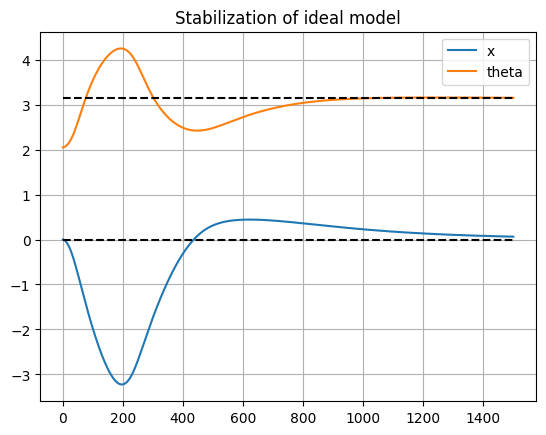

In [4]:
import matplotlib.pyplot as plt

qhist = np.array(qhist)
plt.title("Stabilization of ideal model")
plt.plot(qhist[:, 0], label="x")
plt.plot(qhist[:, 1], label="theta")

plt.hlines(0, 0, len(qhist), color="black", linestyle="--")
plt.hlines(np.pi, 0, len(qhist), color="black", linestyle="--")

plt.grid()
plt.legend()
plt.show()

# Try to balance the pole with the uncertain model

We alter dynamical parameters of the cart-pole system as if we were unsure of them and made a guess


In [5]:
# create a model with uncertainty, with the same structure as the original model
uncertain_model = mjcf.from_path("data/models/cart_pole/model.xml")
# change the mass of the cart
cart = uncertain_model.find("body", "cart")
cart.inertial.mass = 1  # from 0.5 to 1.0

# change the mass of the pole
pole = uncertain_model.find("body", "pole")
pole.inertial.mass = 0.5  # from 0.1 to 0.5
# change the length of the pole
pole.inertial.pos[2] = -0.9  # from -0.5 to -0.9
# compute the new diag inertia
# compute inertia of sphere with radius 0.05
inertia = 2 / 5 * 0.05**2 * pole.inertial.mass
pole.inertial.diaginertia = np.array([inertia] * 3)

# create a model with uncertainty
uncertain_model = mjcf.Physics.from_mjcf_model(uncertain_model).model._model
uncertain_data = mujoco.MjData(uncertain_model)

ctrl0, K = compute_gains(uncertain_model, uncertain_data, target, Q, R)

# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)
sim_data.qpos = qpos0

qhist_uncertain = []

while sim_data.time < DURATION:
    # Get state difference dx.
    mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
    dx = np.hstack((dq, sim_data.qvel)).T

    # LQR control law.
    sim_data.ctrl = ctrl0 - K @ dx + np.random.randn(sim_model.nu) * BALANCE_STD

    # Step the simulation.
    mujoco.mj_step(sim_model, sim_data)

    # Save history.
    qhist_uncertain.append(sim_data.qpos.copy())

[0. 0.]


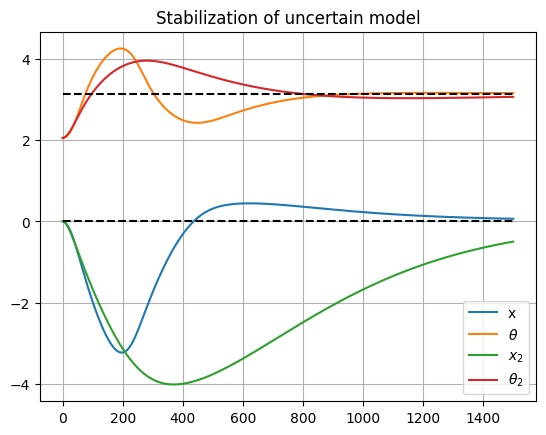

In [6]:
import matplotlib.pyplot as plt

qhist_uncertain = np.array(qhist_uncertain)
plt.title("Stabilization of uncertain model")
plt.plot(qhist[:, 0], label="x")
plt.plot(qhist[:, 1], label="$\\theta$")
plt.plot(qhist_uncertain[:, 0], label="$x_2$")
plt.plot(qhist_uncertain[:, 1], label="$\\theta_2$")

plt.hlines(0, 0, len(qhist), color="black", linestyle="--")
plt.hlines(np.pi, 0, len(qhist), color="black", linestyle="--")

plt.grid()
plt.legend()
plt.show()

It is obvious that even though cart pole with uncertain model can still balance the pole, the controller performance is far from optimal.

In order to tackle this problem, we can gather data from the uncertain model and use it to identify the system dynamics. Then, we can design a controller based on the identified model.


# Random forcing and data gathering

In [7]:
# random forcing and measure data

# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

identification_data = {
    "qhist": [],
    "vhist": [],
    "dvhist": [],
    "uhist": [],
}

for i in range(3000):
    identification_data["qhist"].append(sim_data.qpos.copy())
    identification_data["vhist"].append(sim_data.qvel.copy())

    u = np.random.randn(1) * 10
    identification_data["uhist"].append(u)

    sim_data.ctrl = u
    mujoco.mj_step(sim_model, sim_data)
    identification_data["dvhist"].append(sim_data.qacc.copy())

identification_data["qhist"] = np.array(identification_data["qhist"])
identification_data["vhist"] = np.array(identification_data["vhist"])
identification_data["dvhist"] = np.array(identification_data["dvhist"])
identification_data["uhist"] = np.array(identification_data["uhist"])

# Formulate regressors of system dynamics

$$
\begin{equation}
\begin{cases}
\left(M+m\right){\ddot {p}}-m L \ddot{\theta} \cos \theta +m L \dot{\theta }^{2}\sin \theta = u \\
L \ddot{\theta}- g\sin \theta =\ddot{p} \cos \theta \\
\end{cases}
\end{equation}
$$

where $\theta$ is angle of the pendulum measured from the upper equilibrium and $p$ is position of cart

In form of regressors where we find to estimate the parameters of the system, namely, $M$, $m$, $L$.

$$
\begin{bmatrix}
\ddot{x} & - \ddot{\theta} \cos \theta + \dot{\theta}^2 \sin \theta & 0 \\
0 & 0 & \ddot{\theta} \\
\end{bmatrix} \times \begin{bmatrix}
M + m \\
mL \\
L
\end{bmatrix} = \begin{bmatrix}
u \\
g \sin \theta + \ddot{p} \cos \theta \\
\end{bmatrix}
$$

Next, for each time step, we gather data to form the regressor matrix and the output vector.


In [8]:
# formulate regressor
A = []
b = []

g = 9.81

for i in range(1, len(qhist)):
    q = identification_data["qhist"][i]
    v = identification_data["vhist"][i]
    dv = identification_data["dvhist"][i]
    u = identification_data["uhist"][i]

    regressor = [
        [dv[0], -dv[1] * np.cos(q[1]) + v[1] ** 2 * np.sin(q[1]), 0],
        [0, 0, dv[1]],
    ]

    A.extend(regressor)
    b.extend(
        [
            u[0],
            dv[0] * np.cos(q[1]) + g * np.sin(q[1]),
        ]
    )

A = np.array(A)
b = np.array(b)

# From MJCF we obtain target values for the model

In [9]:
target_params = np.array([0.1 + 0.5, 0.5 * 0.1, 0.5])

target_params

array([0.6 , 0.05, 0.5 ])

# Identify the model


In [10]:
import mujoco.minimize as minimize

result = minimize.least_squares(
    target_params,
    lambda x: (A @ x - b) ** 2,
)

identified_parameters = result[0]

newL = identified_parameters[2]
new_poleM = identified_parameters[1] / newL
new_cartM = identified_parameters[0] - new_poleM

identified_parameters

iter: 0    y: 3.449e+06  log10mu: -inf  ratio: 0.86     dx: 0.11     reduction: 1.5e+06
iter: 1    y: 1.996e+06  log10mu: -inf  ratio: 0.5      dx: 0.004    reduction: 6.3e+02
iter: 2    y: 1.995e+06  log10mu: -inf  ratio: 0.5      dx: 0.002    reduction: 1.6e+02
iter: 3    y: 1.995e+06  log10mu: -inf  ratio: 0.5      dx: 0.00099  reduction: 39     
iter: 4    y: 1.995e+06  log10mu: -inf  ratio: 0.5      dx: 0.00049  reduction: 9.8    
iter: 5    y: 1.995e+06  log10mu: -inf  ratio: 0.5      dx: 0.00025  reduction: 2.4    
iter: 6    y: 1.995e+06  log10mu: -inf  ratio: 0.5      dx: 0.00012  reduction: 0.62   
iter: 7    y: 1.995e+06  log10mu: -inf  ratio: 0.49     dx: 6.2e-05  reduction: 0.15   
iter: 8    y: 1.995e+06  log10mu: -inf  ratio: 0.52     dx: 3.1e-05  reduction: 0.04   
iter: 9    y: 1.995e+06  log10mu: -inf  ratio: 0.47     dx: 1.5e-05  reduction: 0.009  
iter: 10   y: 1.995e+06  log10mu: -inf  ratio: 0.56     dx: 7.7e-06  reduction: 0.0027 
iter: 11   y: 1.995e+06  log10mu

array([0.6       , 0.05      , 0.60295995])

Parameters are close to the real values. Try stabilize with them.


In [11]:
# create a model with identified parameters, with the same structure as the original model
identified_model = mjcf.from_path("data/models/cart_pole/model.xml")
# change the mass of the cart
cart = identified_model.find("body", "cart")
cart.inertial.mass = new_cartM

# change the mass of the pole
pole = identified_model.find("body", "pole")
pole.inertial.mass = new_poleM
# change the length of the pole
pole.inertial.pos[2] = -newL
# compute the new diag inertia
# compute inertia of sphere with radius 0.05
inertia = 2 / 5 * 0.05**2 * pole.inertial.mass
pole.inertial.diaginertia = np.array([inertia] * 3)

# create a model with uncertainty
identified_model = mjcf.Physics.from_mjcf_model(identified_model).model._model
identified_data = mujoco.MjData(identified_model)

ctrl0, K = compute_gains(identified_model, identified_data, target, Q, R)

# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)
sim_data.qpos = qpos0

qhist_identified = []

while sim_data.time < DURATION:
    # Get state difference dx.
    mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
    dx = np.hstack((dq, sim_data.qvel)).T

    # LQR control law.
    sim_data.ctrl = ctrl0 - K @ dx + np.random.randn(sim_model.nu) * BALANCE_STD

    # Step the simulation.
    mujoco.mj_step(sim_model, sim_data)

    # Save history.
    qhist_identified.append(sim_data.qpos.copy())

[0. 0.]


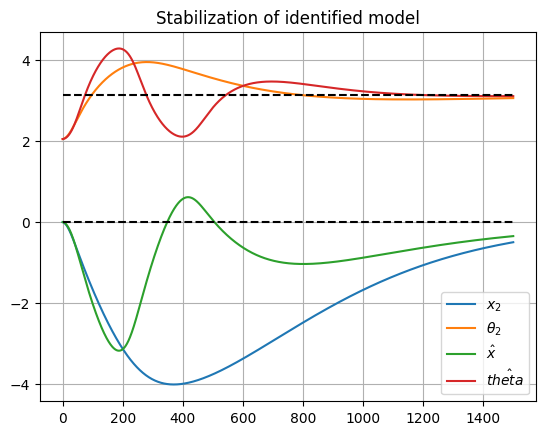

In [12]:
import matplotlib.pyplot as plt

qhist_identified = np.array(qhist_identified)
plt.title("Stabilization of identified model")
# plt.plot(qhist[:, 0], label="x")
# plt.plot(qhist[:, 1], label="$\\theta$")
plt.plot(qhist_uncertain[:, 0], label="$x_2$")
plt.plot(qhist_uncertain[:, 1], label="$\\theta_2$")
plt.plot(qhist_identified[:, 0], label="$\hat{x}$")
plt.plot(qhist_identified[:, 1], label="$\hat{theta}$")

plt.hlines(0, 0, len(qhist), color="black", linestyle="--")
plt.hlines(np.pi, 0, len(qhist), color="black", linestyle="--")

plt.grid()
plt.legend()
plt.show()

# Conclusion:

The system with identified parameters has better performance at stabilizing the pole than the system with uncertain parameters.
